## EDA  and Data Cleaning for Housing

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

/Users/allanshomefolder/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [3]:
df = pd.read_csv('../datasets/train.csv')
pd.set_option('display.max_columns', 100)

In [4]:
df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


## Clean up column names to snake case

In [5]:
df.columns = df.columns.str.lower().str.replace(' ','_').str.replace('qual','quality')

## Checking data types

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
id                    2051 non-null int64
pid                   2051 non-null int64
ms_subclass           2051 non-null int64
ms_zoning             2051 non-null object
lot_frontage          1721 non-null float64
lot_area              2051 non-null int64
street                2051 non-null object
alley                 140 non-null object
lot_shape             2051 non-null object
land_contour          2051 non-null object
utilities             2051 non-null object
lot_config            2051 non-null object
land_slope            2051 non-null object
neighborhood          2051 non-null object
condition_1           2051 non-null object
condition_2           2051 non-null object
bldg_type             2051 non-null object
house_style           2051 non-null object
overall_quality       2051 non-null int64
overall_cond          2051 non-null int64
year_built            2051 non-null int

In [7]:
df["Functional"]: df["functional"].astype('category')
df.dtypes   
pd.Categorical(df["functional"],
               categories = [
                   "Sal",
                   "Sev",
                   'Maj2',
                   "Maj1",
                   "Mod",
                   "Min2",
                   "Min1",
                   "Typ",], ordered = True )

[Typ, Typ, Typ, Typ, Typ, ..., Typ, Typ, Typ, Typ, Typ]
Length: 2051
Categories (8, object): [Sal < Sev < Maj2 < Maj1 < Mod < Min2 < Min1 < Typ]

In [8]:
# Split Columns into Categories and numeric

category_cols = df.select_dtypes(include=object).columns
num_cols = df.drop(category_cols, axis=1).columns

### Checking for Outliers and Impossible Values

In [9]:
# Look for outliers
df.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
id,2051.0,1.474034e+03,8.439808e+02,1.0,753.5,1486.0,2198.0,2930.0
pid,2051.0,7.135900e+08,1.886918e+08,526301100.0,528458140.0,535453200.0,907180080.0,924152030.0
ms_subclass,2051.0,5.700878e+01,4.282422e+01,20.0,20.0,50.0,70.0,190.0
lot_frontage,1721.0,6.905520e+01,2.326065e+01,21.0,58.0,68.0,80.0,313.0
lot_area,2051.0,1.006521e+04,6.742489e+03,1300.0,7500.0,9430.0,11513.5,159000.0


In [10]:
# Garage_yr_blt has an unreasonable construction date in the future.  I'll drop this row, 
# at least until 2207
df['garage_yr_blt'].sort_values(ascending=False).head()

1699    2207.0
144     2010.0
1241    2010.0
589     2009.0
1796    2009.0
Name: garage_yr_blt, dtype: float64

In [11]:
# This house was built in 2006 so garage is likely a typo of 2007

df.loc[1699, 'year_built']
df.loc[1699, 'garage_yr_blt']= 2007

In [12]:
def check_data(dataframe):
    print(dataframe.head())
    print('')
    print('='*25)
    print('')
    msno.matrix(dataframe)
    print('')
    print('='*25)
    print('')
    print(df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending = False))
    print('')
    print('='*25)
    print('')
    print(dataframe.info())

    id        pid  ms_subclass  lot_frontage  lot_area  overall_quality  \
0  109  533352170           60           NaN     13517                6   
1  544  531379050           60          43.0     11492                7   
2  153  535304180           20          68.0      7922                5   
3  318  916386060           60          73.0      9802                5   
4  255  906425045           50          82.0     14235                6   

   overall_cond  year_built  year_remod/add  mas_vnr_area  bsmtfin_sf_1  \
0             8        1976            2005         289.0         533.0   
1             5        1996            1997         132.0         637.0   
2             7        1953            2007           0.0         731.0   
3             5        2006            2007           0.0           0.0   
4             8        1900            1993           0.0           0.0   

   bsmtfin_sf_2  bsmt_unf_sf  total_bsmt_sf  1st_flr_sf  2nd_flr_sf  \
0           0.0        192.

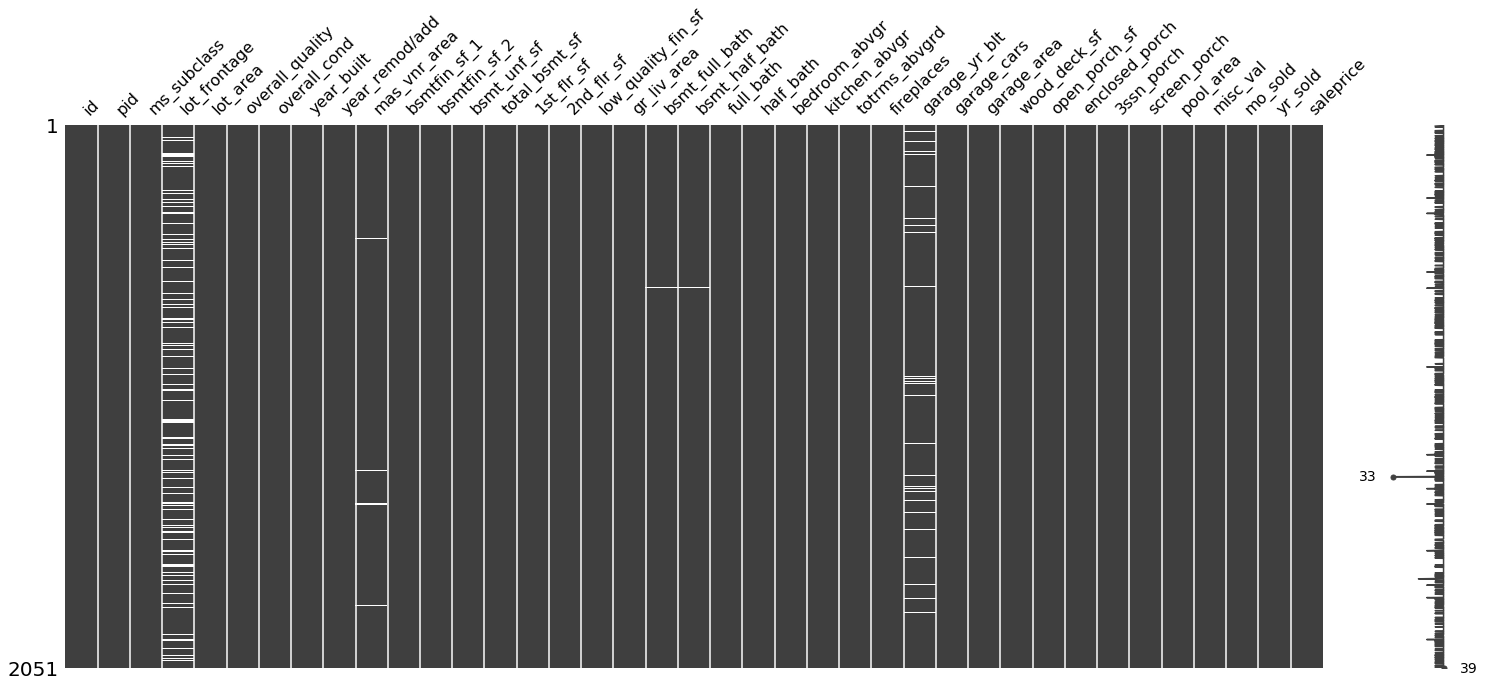

In [13]:
check_data(df[num_cols])

In [14]:
# df[num_cols].fillna({np.NaN: 0}, inplace=True)
# df.loc.num_cols.fillna(value=0, inplace=True)
df[num_cols]=df[num_cols].fillna(0)
df[num_cols].isnull().sum()

id                    0
pid                   0
ms_subclass           0
lot_frontage          0
lot_area              0
overall_quality       0
overall_cond          0
year_built            0
year_remod/add        0
mas_vnr_area          0
bsmtfin_sf_1          0
bsmtfin_sf_2          0
bsmt_unf_sf           0
total_bsmt_sf         0
1st_flr_sf            0
2nd_flr_sf            0
low_quality_fin_sf    0
gr_liv_area           0
bsmt_full_bath        0
bsmt_half_bath        0
full_bath             0
half_bath             0
bedroom_abvgr         0
kitchen_abvgr         0
totrms_abvgrd         0
fireplaces            0
garage_yr_blt         0
garage_cars           0
garage_area           0
wood_deck_sf          0
open_porch_sf         0
enclosed_porch        0
3ssn_porch            0
screen_porch          0
pool_area             0
misc_val              0
mo_sold               0
yr_sold               0
saleprice             0
dtype: int64

## Get Dummies for Categorical Columns

In [15]:
df[category_cols].head()

,ms_zoning,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,exter_quality,exter_cond,foundation,bsmt_quality,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_type_2,heating,heating_qc,central_air,electrical,kitchen_quality,functional,fireplace_qu,garage_type,garage_finish,garage_quality,garage_cond,paved_drive,pool_qc,fence,misc_feature,sale_type
0,RL,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,Gable,CompShg,HdBoard,Plywood,BrkFace,Gd,TA,CBlock,TA,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD
1,RL,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD
2,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,Gd,CBlock,TA,TA,No,GLQ,Unf,GasA,TA,Y,SBrkr,Gd,Typ,NaN,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD
3,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Gd,Y,SBrkr,TA,Typ,NaN,BuiltIn,Fin,TA,TA,Y,NaN,NaN,NaN,WD
4,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,Gable,CompShg,Wd Sdng,Plywood,None,TA,TA,PConc,Fa,Gd,No,Unf,Unf,GasA,TA,Y,SBrkr,TA,Typ,NaN,Detchd,Unf,TA,TA,N,NaN,NaN,NaN,WD


In [31]:
df_dummies =pd.get_dummies(df,drop_first=True)
df_dummies.columns = df_dummies.columns.str.lower()
df_dummies.to_csv('../datasets/df_dummies_clean.csv')

In [32]:
def corr_rank (df, target):
    
    """
    df = pandas dataframe or matrix
    target = target variable or column from dataframe
    """
    y= df[target]
    plt.figure(figsize=(10,50))
    sns.heatmap(df.corr()[[target]].sort_values(by = target, 
                                                    ascending=False),
               annot = True,
               cmap='RdBu_r',

               );

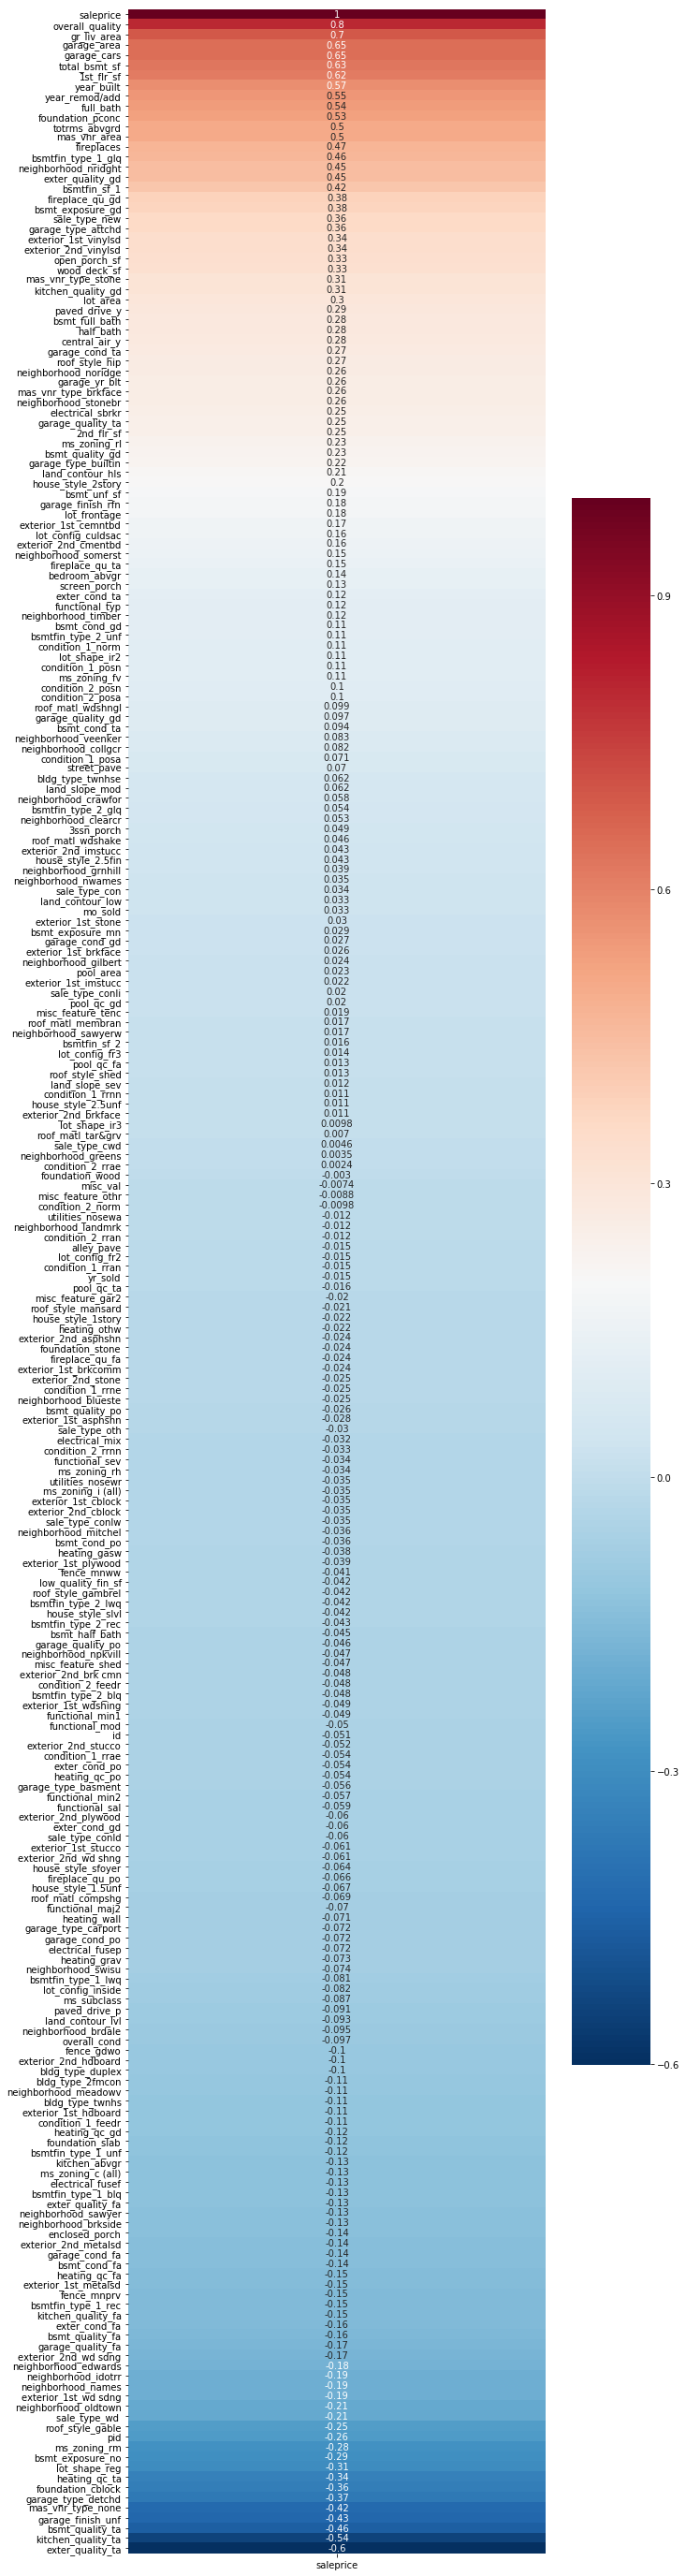

In [24]:
corr_rank(df_dummies, 'saleprice')

In [26]:
features_Q=['exter_quality_ta','kitchen_quality_ta',
            'bsmt_quality_ta','garage_finish_unf',
            'mas_vnr_type_none','garage_type_detchd',
            'overall_quality','gr_liv_area',
            'garage_area','garage_cars',
            'total_bsmt_sf','1st_flr_sf',
            'year_built','year_remod/add',
            'full_bath','foundation_pconc',
            'totrms_abvgrd','mas_vnr_area'
            ]
X_Q= df_dummies[features_Q]
y= df_dummies['saleprice']

In [27]:
# Pairplot to check correlations for selected vars
sns.pairplot(df, x_vars =y, y_vars=features_Q)

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x1c141c9158> (for post_execute):


ValueError: Image size of 369180x3240 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 369180x3240 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 369180x3240 with 3143 Axes>

## Null Value Description

|***Column Name |Description|Type|Number of Nulls|Null Total***|
|

### EDA
- Check which neghborhoods have correlation
     - Make dummy columns and check correlation
     - drop the ones that don't
- 

In [28]:
def plt_subplots(df, columns,y_var, ncols=2):
    nrows = int(np.ceil((len(columns))/2))
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = (10, 2.5 * nrows))
    plt.style.use('bmh')
    plt.tight_layout(pad=3)
#this is the most important line of the function.  .ravel returns a flattened array
#    of the data instead of a matrix.
    ax = ax.ravel()
    for i, col in enumerate(columns):
        
        if i % 2 == 0:
            color = 'blue'
            alpha = 0.7
        else:
            color = 'black'
            alpha = 0.8

        ax[i].scatter(df[col], y=y_var, color=color, alpha=alpha, s=2 )       #plot histogram
        ax[i].set_title(col)
        ax[i].set_ylabel('Price')
        ax[i].set_xlabel(col)
        ax[i].axvline(df[col].mean(), color='red', linewidth=2)   # Mean line
        

In [29]:
def plot_vars(model, X, y, ncols=2):
    """
    model = regression model
    X = matrix or dataframe of features
    y = target value series
    ncols= number of columns of scatter charts"""
    
    nrows = int(np.ceil((len(X))/2))
#     plt.figure(figsize=(12,9))
    plt.style.use('bmh')
    #plt.tight_layout(pad=3);
#     fig, ax = plt.subplots(1,len(X.columns.values),
#                            ncols=ncols,
#                            sharey=True
                          #constrained_layout=True)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = (10, 2.5 * nrows))
    for i,e in enumerate(X.columns):
      model=model()
      model.fit(X[e].values[:,np.newaxis], y.values)
      ax[i].set_title("Best fit line")
      ax[i].set_xlabel(str(e))
      ax[i].set_ylabel('Sale Price')
      ax[i].scatter(X[e].values[:,np.newaxis], y,color='g')
      ax[i].plot(X[e].values[:,np.newaxis], 
      model.predict(X[e].values[:,np.newaxis]),color='k')
# Generate a scatterplot of predicted values versus actual values.
    plt.scatter(model.predict(X), y, s=8, color='skyblue', alpha = 0.9)

# Plot a line.
    plt.plot([0, np.max(y)],
             [0, np.max(y)],
             color = 'black')

 # Tweak title and axis labels.
    plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 20)
    plt.ylabel("Actual Values: $y$", fontsize = 20)
    plt.text(1,1,'Pre', transform=ax[i].transAxes)
    plt.title('Predicted Values vs. Actual Values', fontsize = 24);

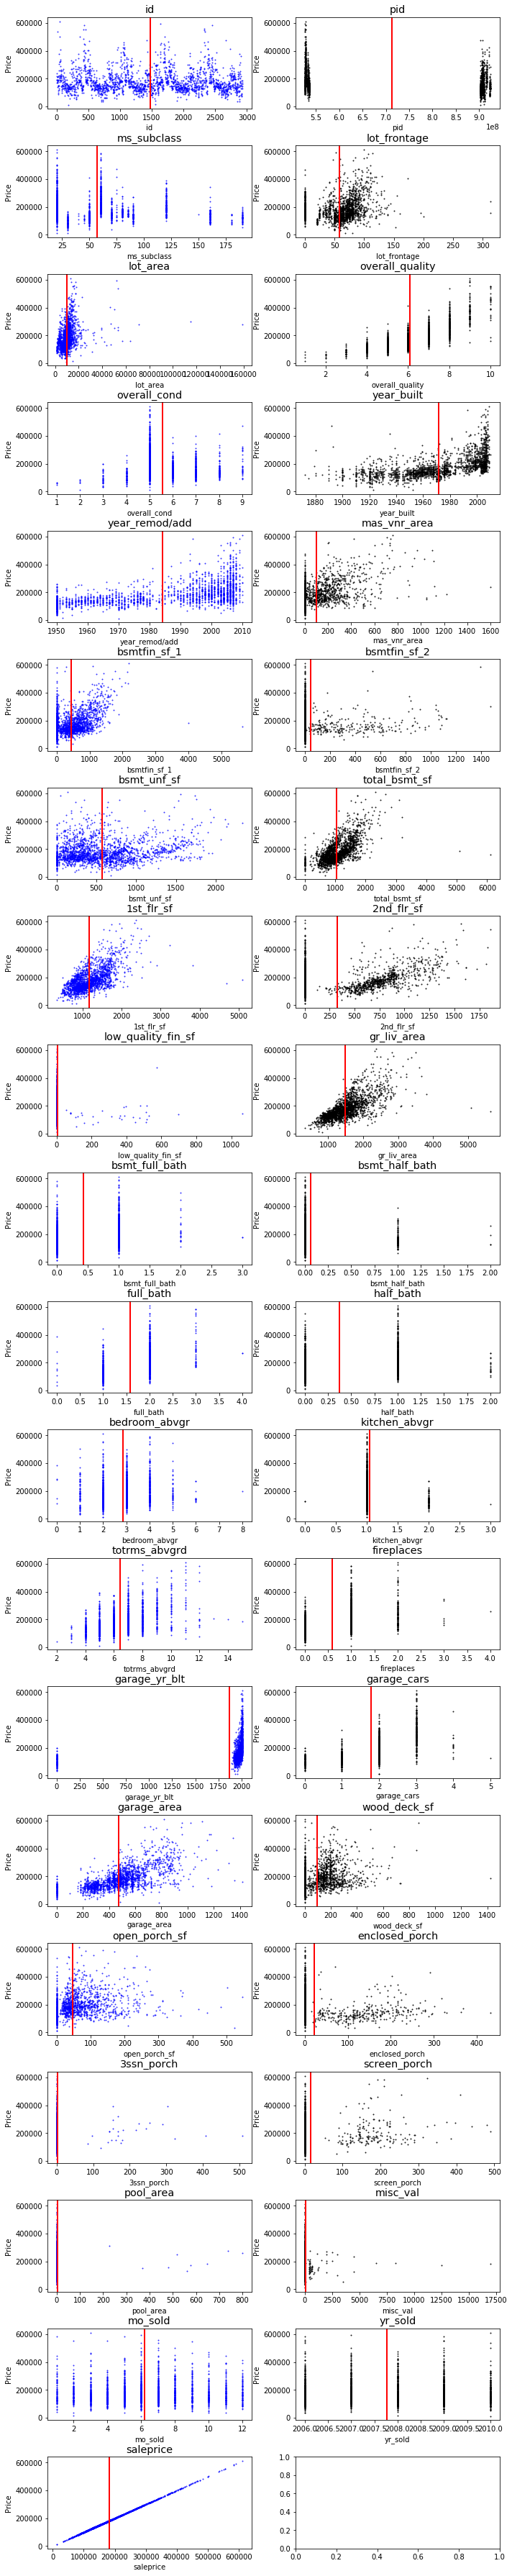

In [30]:
plt_subplots(df, num_cols, df['saleprice'])

There are some numeric columns that I can drop fromm my analysis.
- pid
- id
- bsmtfin_sf_2
- bsmt_unf_sf
- low_quality_fin_sf
- bsmt_full_bath
- bsmt_half_bath
- kitchen_abvgr
- 3ssn_porch
- screen_porch
- pool_area
- misc_val

In [60]:
features=num_cols.drop(['pid',
'id',
'bsmtfin_sf_2',
'bsmt_unf_sf',
'low_quality_fin_sf',
'bsmt_full_bath',
'bsmt_half_bath',
'kitchen_abvgr',
'3ssn_porch',
'screen_porch',
'pool_area',
'misc_val',
'saleprice'
])
features

Index(['ms_subclass', 'lot_frontage', 'lot_area', 'overall_quality',
       'overall_cond', 'year_built', 'year_remod/add', 'mas_vnr_area',
       'bsmtfin_sf_1', 'total_bsmt_sf', '1st_flr_sf', '2nd_flr_sf',
       'gr_liv_area', 'full_bath', 'half_bath', 'bedroom_abvgr',
       'totrms_abvgrd', 'fireplaces', 'garage_yr_blt', 'garage_cars',
       'garage_area', 'wood_deck_sf', 'open_porch_sf', 'enclosed_porch',
       'mo_sold', 'yr_sold'],
      dtype='object')

In [61]:
X=df[features]
y=df['saleprice']

In [62]:
plot_vars(LinearRegression, X, y)

AttributeError: 'numpy.ndarray' object has no attribute 'set_title'

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x1c17d708c8> (for post_execute):


ValueError: Image size of 720x184680 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 720x184680 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 720x184680 with 2052 Axes>

In [63]:
# Create a baseline score
lr = LinearRegression()
cross_val_score(lr,X, y, cv=5).mean()

0.8104234390198896

ms_subclass        0
lot_frontage       0
lot_area           0
overall_quality    0
overall_cond       0
year_built         0
year_remod/add     0
mas_vnr_area       0
bsmtfin_sf_1       0
total_bsmt_sf      0
1st_flr_sf         0
2nd_flr_sf         0
gr_liv_area        0
full_bath          0
half_bath          0
bedroom_abvgr      0
totrms_abvgrd      0
fireplaces         0
garage_yr_blt      0
garage_cars        0
garage_area        0
wood_deck_sf       0
open_porch_sf      0
enclosed_porch     0
mo_sold            0
yr_sold            0
saleprice          0
dtype: int64